In [1]:
import eland as ed
import numpy as np
import matplotlib.pyplot as plt
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
%%capture
ticker = "NVDA"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_obv = ed.eland_to_pandas(df_eod).sort_values(by='date_reference', ascending=True).tail(100).set_index(
    'date_reference')

In [4]:
# Calculate daily close change
df_obv['prev_close'] = df_obv['val_close'].shift(1)
df_obv['close_change'] = df_obv['val_close'] - df_obv['prev_close']

# Calculate signed volume: +volume if up, -volume if down, 0 if flat
df_obv['signed_volume'] = np.where(
    df_obv['close_change'] > 0, df_obv['val_volume'],
    np.where(df_obv['close_change'] < 0, -df_obv['val_volume'], 0)
)

# Calculate OBV (cumulative sum of signed volume)
df_obv['obv'] = df_obv['signed_volume'].cumsum()

# Drop NaN rows (initial prev_close is NaN)
df_obv.dropna(inplace=True)

In [5]:
df_obv.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,prev_close,close_change,signed_volume,obv
date_reference,,,,,,,,,,
2025-10-17,NVDA,183.22,184.100,179.7500,180.180,173135217,181.81,1.41,173135217,2189004165
2025-10-20,NVDA,182.64,185.200,181.7300,183.130,128544711,183.22,-0.58,-128544711,2060459454
2025-10-21,NVDA,181.16,182.785,179.8000,182.785,124240168,182.64,-1.48,-124240168,1936219286
2025-10-22,NVDA,180.28,183.440,176.7600,181.140,162249552,181.16,-0.88,-162249552,1773969734
2025-10-23,NVDA,182.16,183.030,179.7901,180.420,111363718,180.28,1.88,111363718,1885333452


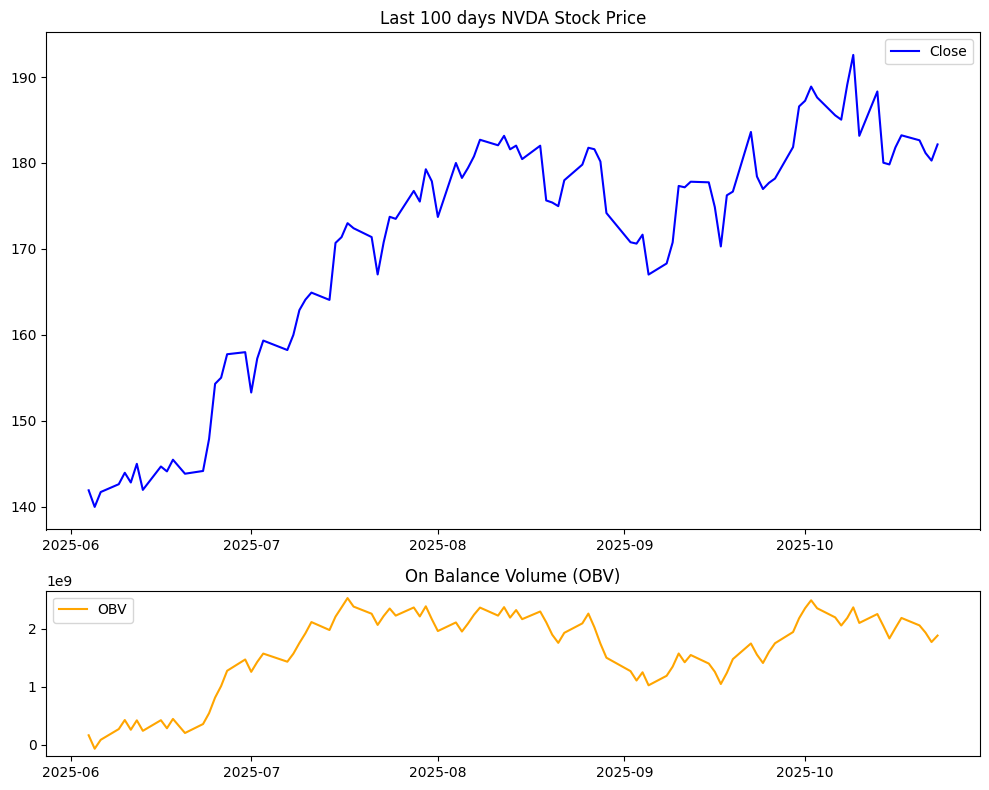

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

# Top: Price plot
axs[0].plot(df_obv.index, df_obv['val_close'], label='Close', color='blue')
axs[0].set_title(f"Last 100 days {ticker} Stock Price")
axs[0].legend()

# Bottom: OBV plot
axs[1].plot(df_obv.index, df_obv['obv'], label='OBV', color='orange')
axs[1].set_title('On Balance Volume (OBV)')
axs[1].legend()

plt.tight_layout()
plt.show()

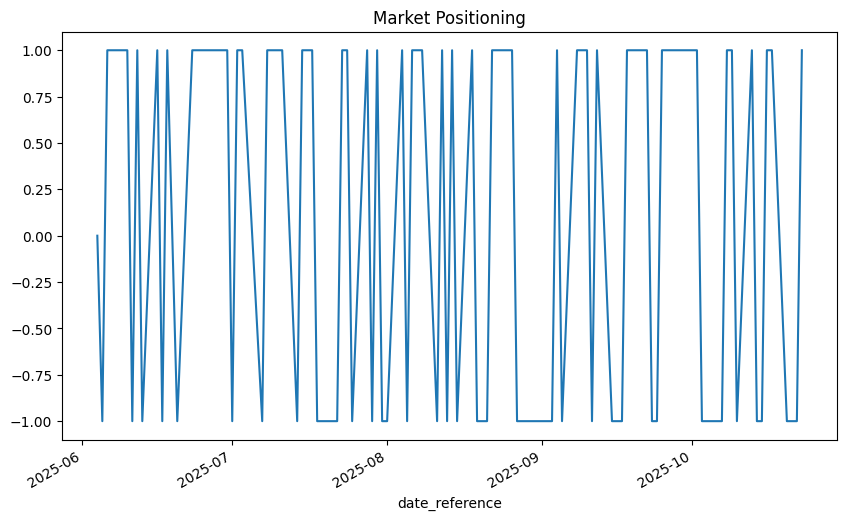

In [7]:
# Generate positions for the strategy (1 for up OBV, -1 for down, 0 flat)
df_obv['obv_change'] = df_obv['obv'].diff()
df_obv['position'] = np.where(df_obv['obv_change'] > 0, 1, np.where(df_obv['obv_change'] < 0, -1, 0))
df_obv['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

In [8]:
df_obv['returns'] = np.log(df_obv['val_close'] / df_obv['val_close'].shift(1))
df_obv['strategy'] = df_obv['position'].shift(1) * df_obv['returns']
df_obv[['returns', 'strategy']].sum().apply(np.exp)

returns     1.283540
strategy    0.875248
dtype: float64

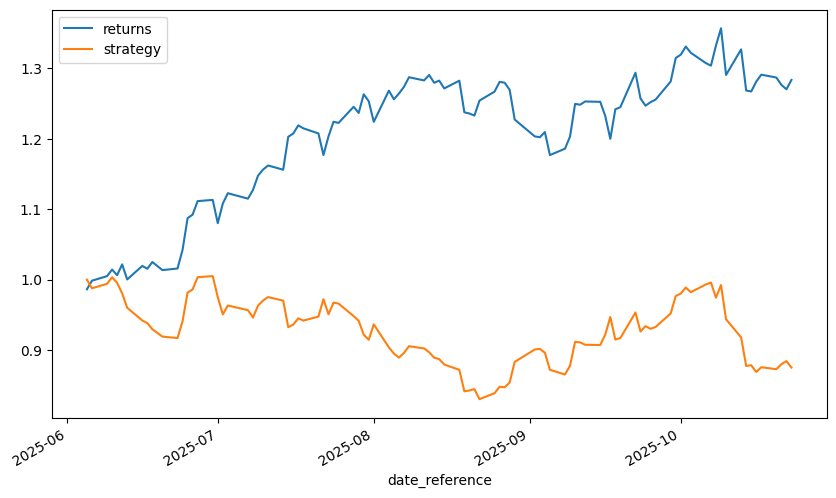

In [9]:
df_obv[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));